In [1]:
import os
import numpy as np
from MyKalmanFilter import MyKalmanFilter
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from talib import  BBANDS, ROC, EMA, MACD
from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter
from scipy.stats import johnsonsu, skew, kurtosis
from arch import arch_model


#from datetime import datetime

data_dir = 'data'

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]

# Initialize an empty list to store DataFrames
df_list = []

# Read each JSON file and append the DataFrame to the list
for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    df = pd.read_json(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df_org = pd.concat(df_list, ignore_index=True)


def compute_average_ask_bid(price_data):
    if( price_data['Ask'] is not None and price_data['Bid'] is not None):
        return (price_data['Ask'] + price_data['Bid']) / 2
    else:
        return None

df_org['openPrices'] = [compute_average_ask_bid(OpenPrice) for OpenPrice in df_org["OpenPrice"]];
df_org['highPrices'] = [compute_average_ask_bid(HighPrice) for HighPrice in df_org["HighPrice"]];
df_org['lowPrices'] = [compute_average_ask_bid(LowPrice) for LowPrice in df_org["LowPrice"]];
df_org['closedprices'] = [compute_average_ask_bid(closedprice) for closedprice in df_org["ClosePrice"]];

## Drop rows with None values
df_org.dropna(subset=['closedprices', 'highPrices', 'lowPrices', 'openPrices'], inplace=True)


# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['closedprices'] / df_org['closedprices'].shift(1))
df_org['returns'] = df_org['closedprices'] / df_org['closedprices'].shift(1)
df_org['forward_returns'] = df_org['log_returns'].shift(-1)
df_org['momentum'] = np.log(df_org['closedprices']/df_org['closedprices'].shift(20))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

# Extract unique days
df_org['Date'] = df_org['SnapshotTime'].dt.date
unique_days = df_org['Date'].unique()

df_org.head()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,closedprices,olhc4,log_returns,returns,forward_returns,momentum,Date
0,"{'Ask': 7290.0, 'Bid': 7288.0, 'LastTraded': N...","{'Ask': 7297.0, 'Bid': 7294.0, 'LastTraded': N...",74,"{'Ask': 7288.7, 'Bid': 7286.7, 'LastTraded': N...","{'Ask': 7296.2, 'Bid': 7293.2, 'LastTraded': N...",2024-11-18 08:00:00,2024-11-18T07:00:00,7294.7,7295.5,7287.7,7289.0,7291.725,NaN,NaN,-0.001002,NaN,2024-11-18
1,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",53,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",2024-11-18 08:01:00,2024-11-18T07:01:00,7288.0,7288.0,7281.7,7281.7,7284.850,-0.001002,0.998998,-0.000646,NaN,2024-11-18
2,"{'Ask': 7278.0, 'Bid': 7276.0, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",18,"{'Ask': 7277.7, 'Bid': 7275.7, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",2024-11-18 08:02:00,2024-11-18T07:02:00,7282.2,7282.2,7276.7,7277.0,7279.525,-0.000646,0.999355,0.000714,NaN,2024-11-18
3,"{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",25,"{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...","{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...",2024-11-18 08:03:00,2024-11-18T07:03:00,7277.2,7282.2,7277.2,7282.2,7279.700,0.000714,1.000715,-0.000481,NaN,2024-11-18
4,"{'Ask': 7279.7, 'Bid': 7277.7, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",22,"{'Ask': 7279.2, 'Bid': 7277.2, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",2024-11-18 08:04:00,2024-11-18T07:04:00,7282.0,7282.0,7278.2,7278.7,7280.225,-0.000481,0.999519,0.000110,NaN,2024-11-18


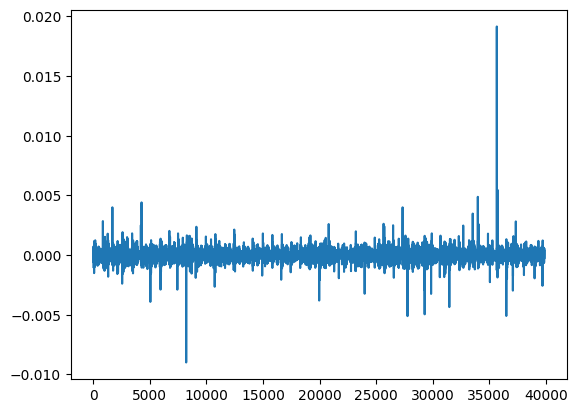

In [2]:


plt.plot(df_org['log_returns'] )
plt.show()

In [3]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39819 entries, 0 to 39868
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ClosePrice        39819 non-null  object        
 1   HighPrice         39819 non-null  object        
 2   LastTradedVolume  39819 non-null  int64         
 3   LowPrice          39819 non-null  object        
 4   OpenPrice         39819 non-null  object        
 5   SnapshotTime      39819 non-null  datetime64[ns]
 6   SnapshotTimeUTC   39819 non-null  object        
 7   openPrices        39819 non-null  float64       
 8   highPrices        39819 non-null  float64       
 9   lowPrices         39819 non-null  float64       
 10  closedprices      39819 non-null  float64       
 11  olhc4             39819 non-null  float64       
 12  log_returns       39818 non-null  float64       
 13  returns           39818 non-null  float64       
 14  forward_returns   39818 non

In [4]:
import numpy as np

up, mid, low = BBANDS(df_org.closedprices, timeperiod=60, nbdevup=0.8, nbdevdn=0.8, matype=0)
roc10= ROC(df_org.closedprices, timeperiod=10 )
roc13= ROC(df_org.closedprices, timeperiod=13 )
roc15= ROC(df_org.closedprices, timeperiod=15 )
roc20= ROC(df_org.closedprices, timeperiod=20 )
#kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)


kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.01) # 0.01 0.05 .001

mykf = MyKalmanFilter(transition_matrix=1, 
                    observation_matrix=1, 
                    initial_state_mean=0, 
                    initial_state_covariance=1, 
                    observation_covariance=1, 
                    transition_covariance=0.01)


kf2 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.1) #.1 .0001 .05

#kstmt = 1.618 * roc10 +  1.5*roc13 +  1.382 * roc15+ 1.236*roc20
kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)


#olhc4_filter, prediction = mykf.filter(df_org['closedprices']);

olhc4_filter, _ = kf.filter(df_org['closedprices'])
olhc4_filter2, _ = kf2.filter(df_org['closedprices'])
#

diff = olhc4_filter2 - olhc4_filter
#prediction

roc300= ROC(df_org.closedprices, timeperiod=50 )
roc400= ROC(df_org.closedprices, timeperiod=100 )
roc600= ROC(df_org.closedprices, timeperiod=150 )
roc800= ROC(df_org.closedprices, timeperiod=200 )
#kstlt = 1.618 * EMA(roc300, 30) +  1.5*EMA(roc400,40) +  1.382 * EMA(roc600,60) + 1.236*EMA(roc800,80)
kstlt = 1.618 * roc300 +  1.5*roc400 +  1.382 * roc600 + 1.236 *roc800

kstmtup, kstmtmid, kstmtlow = BBANDS(kstmt, timeperiod=10, nbdevup=1.1, nbdevdn=1.1, matype=0)

df_org['roc10'] = roc10
df_org['kstmt'] = kstmt 
df_org['kstmtup'] = kstmtup
df_org['kstmtmid'] = kstmtmid
df_org['kstmtlow'] =  kstmtlow
df_org['kstlt'] = kstlt 
df_org['up'] = up
df_org['low'] = low
df_org['diff'] = diff
df_org['olhc4_filter'] = olhc4_filter
df_org['olhc4_filter2'] = olhc4_filter2
df_org['upreturn'] = np.log(df_org['up'] / df_org['up'].shift(1))
df_org['lowreturn'] = np.log(df_org['low'] / df_org['low'].shift(1))



In [5]:
#data = pd.DataFrame({'olhc4': df_org['olhc4'], 'upper': up, 'middle': mid, 'lower': low})

In [6]:

#data.plot(figsize=(20, 10), title='Bollinger Bands')

np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
df_org.dropna( inplace=True) # = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", 'kstmtup' "olhc4", "momentum"]].dropna()

features = ['log_returns', "kstmt"  ]  # '',  , "kstlt", "kstmt" , "upreturn", "lowreturn"

print(df_org.shape[0])
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
 
########### Split date for training and testing
split_date = datetime(2024, 12, 6).date()
df_fit= df_org.loc[df_org['Date'] <= split_date]

hmm_model.fit(np.array(df_fit[features]))
print("Model Score: ", hmm_model.score(np.array(df_fit[features])))


39618
Model Score:  65408.94646357334


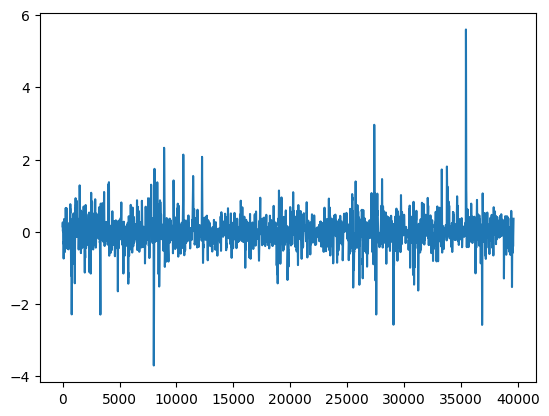

In [7]:
kf3 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.01) # 0.01 0.05


kstmt_filter, _ = kf3.filter(df_org['kstmt'])
kstlt, _ = kf3.filter(df_org['kstlt'])
df_org['kstlt'] =kstlt

kf4 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.0005) # 0.01 0.05


kstmt_filter_speed, _ = kf4.filter(df_org['kstmt'])

plt.plot(kstmt_filter)
df_org['kstmt_filter'] = kstmt #kstmt_filter
df_org['kstmt_filter_speed'] = kstmt_filter_speed

In [8]:
df_fit.tail(5)

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,kstmtmid,kstmtlow,kstlt,up,low,diff,olhc4_filter,olhc4_filter2,upreturn,lowreturn
12401,"{'Ask': 7426.0, 'Bid': 7424.0, 'LastTraded': N...","{'Ask': 7426.8, 'Bid': 7424.8, 'LastTraded': N...",15,"{'Ask': 7426.0, 'Bid': 7424.0, 'LastTraded': N...","{'Ask': 7426.5, 'Bid': 7424.5, 'LastTraded': N...",2024-12-06 21:56:00,2024-12-06T20:56:00,7425.50,7425.8,7425.0,...,0.051770,0.028732,0.557763,7424.206146,7420.793854,0.803874,7424.544998,7425.348872,0.000011,0.000009
12402,"{'Ask': 7428.0, 'Bid': 7426.0, 'LastTraded': N...","{'Ask': 7428.3, 'Bid': 7426.3, 'LastTraded': N...",38,"{'Ask': 7426.3, 'Bid': 7424.3, 'LastTraded': N...","{'Ask': 7426.3, 'Bid': 7424.3, 'LastTraded': N...",2024-12-06 21:57:00,2024-12-06T20:57:00,7425.30,7427.3,7425.3,...,0.056495,0.026467,0.710674,7424.361016,7420.905650,1.016405,7424.778530,7425.794935,0.000021,0.000015
12403,"{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...","{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...",20,"{'Ask': 7427.3, 'Bid': 7425.3, 'LastTraded': N...","{'Ask': 7427.8, 'Bid': 7425.8, 'LastTraded': N...",2024-12-06 21:58:00,2024-12-06T20:58:00,7426.80,7427.5,7426.3,...,0.065375,0.026012,0.749393,7424.534159,7420.982508,1.218159,7425.037410,7426.255569,0.000023,0.000010
12404,"{'Ask': 7429.0, 'Bid': 7427.0, 'LastTraded': N...","{'Ask': 7429.8, 'Bid': 7427.8, 'LastTraded': N...",127,"{'Ask': 7427.5, 'Bid': 7425.5, 'LastTraded': N...","{'Ask': 7428.3, 'Bid': 7426.3, 'LastTraded': N...",2024-12-06 21:59:00,2024-12-06T20:59:00,7427.30,7428.8,7426.5,...,0.080003,0.032556,0.771755,7424.719840,7421.096827,1.407612,7425.319226,7426.726838,0.000025,0.000015
12405,"{'Ask': 7430.3, 'Bid': 7426.3, 'LastTraded': N...","{'Ask': 7430.6, 'Bid': 7426.6, 'LastTraded': N...",0,"{'Ask': 7428.3, 'Bid': 7424.3, 'LastTraded': N...","{'Ask': 7429.9, 'Bid': 7425.0, 'LastTraded': N...",2024-12-06 22:00:00,2024-12-06T21:00:00,7427.45,7428.6,7426.3,...,0.095684,0.041475,0.794395,7424.914549,7421.168784,1.549066,7425.602772,7427.151837,0.000026,0.000010


In [9]:
df_org['state']=hmm_model.predict(np.array(df_org[features]))

5.0538393807948555e-05
3.500455822348582e-07
-5.767934068786194e-05


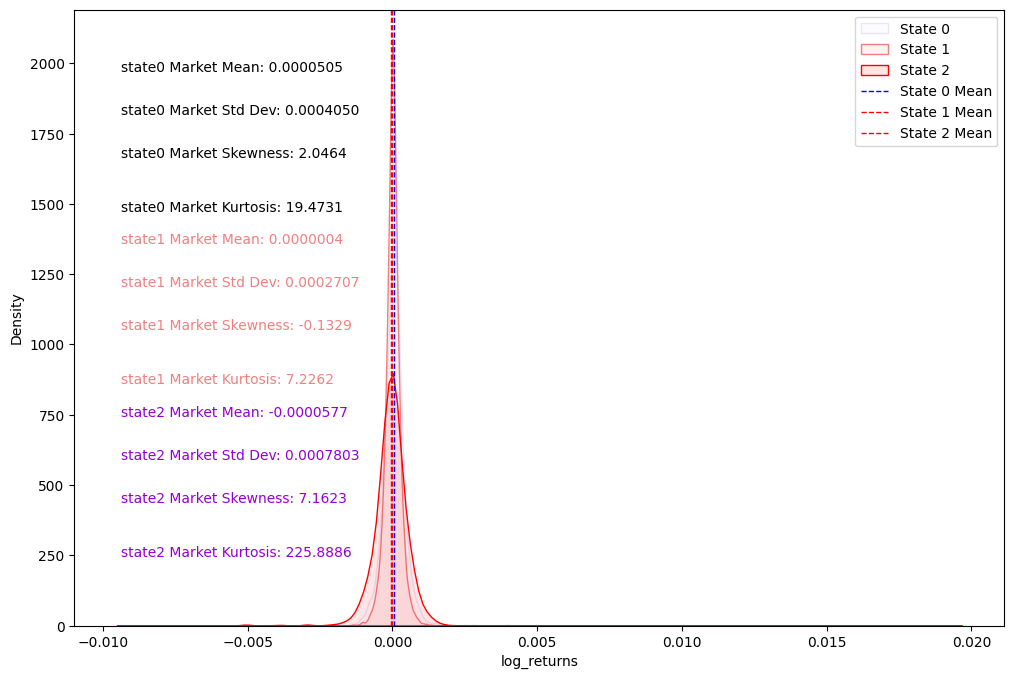

In [10]:
state0 = df_org[df_org['state'] == 0 ]
state1 = df_org[df_org['state'] == 1 ]
state2 = df_org[df_org['state'] == 2 ]


#sns.set_theme(style="dark", rc={"axes.grid": False})

# Définir le style de fond de la figure
#plt.style.use('dark_background')


plt.figure(figsize=(12, 8))
sns.kdeplot(state0['log_returns'], color='lavender', label='State 0', fill=True, alpha=0.1)
sns.kdeplot(state1['log_returns'], color='lightcoral', label='State 1', fill=True, alpha=0.1)
sns.kdeplot(state2['log_returns'], color='red', label='State 2', fill=True, alpha=0.1)
plt.axvline( state0['log_returns'].mean(), color='blue', linestyle='dashed', linewidth=1, label='State 0 Mean')
plt.axvline( state1['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 1 Mean')
plt.axvline( state2['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 2 Mean')
plt.legend()
#state0.head()
#state1.head()

y_cord = 0.90
delt = 0.07 # Ajustez si nécessaire pour mieux adapter les annotations au graphique
for market, color, label in [(state0, 'black', 'state0'), (state1, 'lightcoral', 'state1'), (state2, 'darkviolet', 'state2')]:
    # Calcul des statistiques
    mean = market['log_returns'].mean()
    std_dev = market['log_returns'].std()
    skewness = skew(market['log_returns'])
    kurt = kurtosis(market['log_returns'])

    # Annotations pour la moyenne et l'écart type
    plt.annotate(f'{label} Market Mean: {mean:.7f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Std Dev: {std_dev:.7f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    
    # Annotations pour le skewness et le kurtosis
    plt.annotate(f'{label} Market Skewness: {skewness:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Kurtosis: {kurt:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color, verticalalignment='top')
    y_cord -= delt  # Espacement additionnel avant de passer au prochain marché


print(state0['log_returns'].mean())
print(state1['log_returns'].mean())
print(state2['log_returns'].mean())

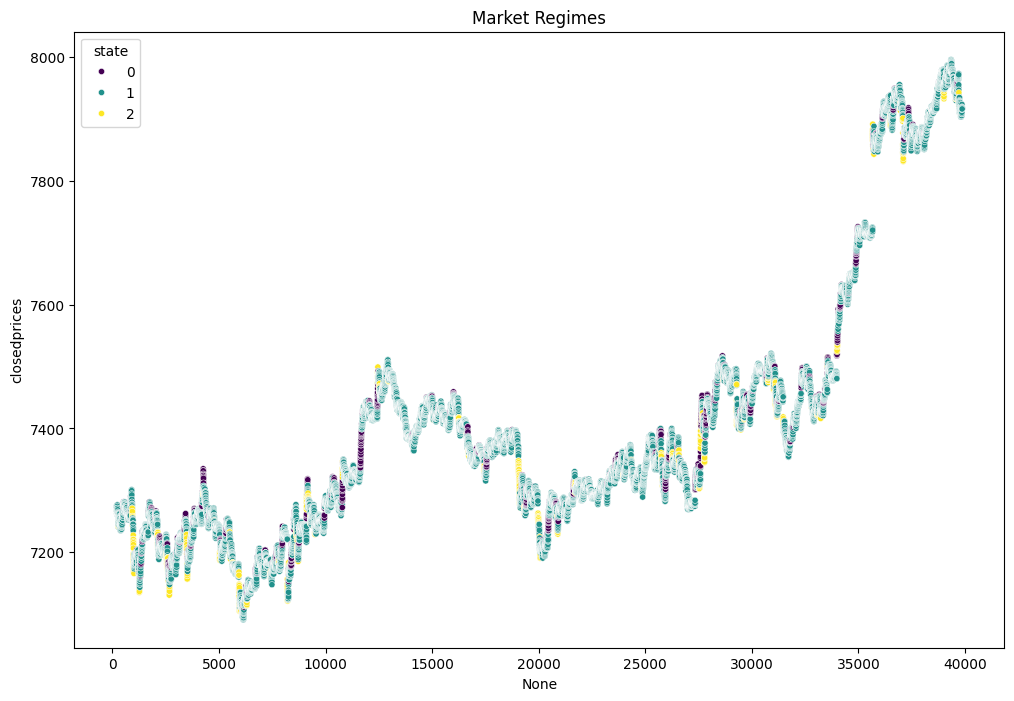

In [11]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_org.index, y='closedprices', hue='state', data=df_org, s=20, palette='viridis')
plt.title('Market Regimes')

plt.show()

In [12]:
#if df_org['state'] == 2 and df_org['state'].shift(1) !=  2:
df_org['position'] = 0
# Set 'position' to 1 where 'state' is 2
df_org.loc[  (df_org['state'] == 0) , 'position'] = 1 # & (df_org['olhc4_filter'] < df_org['olhc4_filter2'])
df_org.loc[  (df_org['state'] == 2) , 'position'] = 2 # & (df_org['olhc4_filter'] > df_org['olhc4_filter2'])

# Define the cutoff time
cutoff_time = pd.to_datetime('18:00:00').time()

#conditions = [
#    (df_org['state'] == 1), # | (df_org['SnapshotTime'].dt.time >= cutoff_time)
#    (df_org['state'] == 0 )   , #buy   &  (df_org['olhc4_filter'] < df_org['olhc4_filter2'])  & (df_org['SnapshotTime'].dt.time < cutoff_time)
#    (df_org['state'] == 2 )   #sell  &  (df_org['olhc4_filter'] > df_org['olhc4_filter2']) & (df_org['SnapshotTime'].dt.time < cutoff_time)
#]


conditions = [
    df_org['kstmt_filter'] == df_org['kstmt_filter'].shift(1),
    (df_org['kstmt_filter'] > df_org['kstmt_filter'].shift(1)) & (df_org['kstlt'] >0),
    (df_org['kstmt_filter'] < df_org['kstmt_filter'].shift(1)) & (df_org['kstlt'] < 0), 
]

#conditions = [
#    df_org['state'] == 0,
#    (df_org['kstlt'] >  0) &  (df_org['olhc4_filter'] < df_org['olhc4_filter2']),
#    (df_org['kstlt']<  0) &  (df_org['olhc4_filter'] > df_org['olhc4_filter2'])
    #   (df_org['state'] != 0) & (df_org['olhc4_filter'] < df_org['olhc4_filter2']),
    #(df_org['state'] != 0) & (df_org['olhc4_filter'] > df_org['olhc4_filter2'])
#]


choices = [
    0,
    1,
    -1
]

fee = 0 # 0.0001

df_org['signal'] = np.select(conditions, choices, default=0)
df_org['shifted_signal'] = df_org['signal'].shift(1)
df_org['fee'] = np.where(df_org['signal'] != df_org['shifted_signal'], fee, 0)
df_org['backtest'] = df_org['forward_returns'] * df_org['signal'] - df_org['fee']
df_org['operation'] = np.where(df_org['signal'] != df_org['shifted_signal'], 1, 0)

#df_org['kstlt_covariance'] = df_org['kstmt'].rolling(window=10).cov(df_org['olhc4_filter']) #.diff()*100
#df_org['kstlt_covariance'] = df_org['kstmt'].rolling(window=10).cov(df_org['olhc4_filter2']) #.diff()*100
#df_org['kstlt_covariance'] = df_org['kstlt'].rolling(window=10).cov(df_org['olhc4_filter']) #.diff()*100
#df_org['kstlt_covariance'] = df_org['kstlt'].rolling(window=10).cov(df_org['olhc4_filter2']) #.diff()*100
df_org['kstlt_covariance'] = df_org['low'].rolling(window=10).cov(df_org['olhc4_filter2']) #.diff()*100

df_org['rolling_std'] = df_org['closedprices'].rolling(window=10).std()

df_test= df_org.loc[df_org['Date'] > split_date]

In [32]:

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# si cond volat superieur a 4 alors trade avec kalman filter si inferiruer a 4 alors trade avec signe kstlt et retournemant de kstmt 
# pas de trad si cond volat < 2


#superieur a 3 pour kst mt

#=>pour day 16 si le kalman rapide sort des bollinger alors on mets on place un support/resistance si on casse on rentre dans le sens de la cassure
#=>pour day 44 si le kalman lent passe jaune au rouge  alors on mets on place un support/resistance si on casse on rentre dans le sens de la cassure

# ======> le kst lt sert a determiner la tendance de fond si > 0 alors on est en tendance haussiere si < 0 alors on est en tendance baissiere on uyilise ensuite kalman pour renter dans le sens de la tendance
# on attend que le kalman lent soit dans le sens de la tendance  si on casse la bougie qui a fait changer la couleur du kalman lent alors on rentrer dans le trade
# si kalman lent est deja de la bonne couleur on attend que le kalman rapide soit de nouveau dans notre sens et que lon casse la bougie qui a fait changer le kalman rapide

# Add traces for the initial plot (first day)
initial_day = unique_days[44] #16 17 4 5 6 8 9 (jour 16 17 !!! 31) (4 ok, 8 avec suivi kalman ) voir 33 34 35 36 37
print(initial_day)

df_day = df_org[df_org['Date'] == initial_day]

# Fit an ARCH model
model = arch_model( df_day['returns'] * 10000, vol='GARCH', p=3)
model_fit = model.fit(disp='off')
conditional_volatility = model_fit.conditional_volatility

df_day['conditional_volatility'] = conditional_volatility

def getTEvents(gRaw,h):
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.Index(tEvents)

anomalies = getTEvents(df_day['closedprices'], h=2) # REQUIREMENT 4 kstmt 0.5


df_buy = df_day.loc[df_org['signal']  == 1,['SnapshotTime','closedprices']]
df_sell = df_day.loc[df_org['signal']  == -1, ['SnapshotTime','closedprices']]

df_operation = df_day.loc[df_org['operation']  == 1, ['SnapshotTime','closedprices']]

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['conditional_volatility']   , #-df_day['kstmt_filter_speed'] )*15, conditional_volatility
#                         name = 'covariance',
#                         opacity = 1), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['rolling_std']   , #-df_day['kstmt_filter_speed'] )*15,
#                         name = 'rolling_std',
#                         opacity = 1), row=1, col=1)

#fig.append_trace(go.Scatter(x=df_day['SnapshotTime'].loc[anomalies.tolist()], y=df_day['conditional_volatility'].loc[anomalies.tolist()] , mode='markers',
#    marker=dict(symbol='x', size=15, line=dict(width=1), color='blue'), name = 'filter'), row=1, col=1)

#fig.append_trace(go.Scatter(x=df_day['SnapshotTime'].loc[anomalies.tolist()], y=df_day['rolling_std'].loc[anomalies.tolist()] , mode='markers',
#    marker=dict(symbol='x', size=15, line=dict(width=1), color='red'), name = 'filter'), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmt_filter_speed'],
#                         name = 'kstmt',
#                         opacity = 1), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmtmid'],
#                         name = 'kstmtmid',
#                         opacity = 0.5), row=2, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmtup'],
#                        line_color = 'gray',
#                         line = {'dash': 'dash'},
#                         name = 'kst upper band',
#                         opacity = 0.5), row=1, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['kstmtlow'],
#                         line_color = 'gray',
#                         line = {'dash': 'dash'},
#                         fill = 'tonexty',
#                         name = 'lower band',
#                         opacity = 0.3), row=1, col=1)




fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmt'], #kstmt_filter
                          line_color = 'red',
                         name = 'kstmt',
                         #marker=mark,
                         #mode='markers',
                         opacity = 1), row=1, col=1)

#fig.append_trace(go.Scatter(x=df_day['SnapshotTime'].loc[anomalies.tolist()], y=df_day['kstmt'].loc[anomalies.tolist()] , mode='markers',
#    marker=dict(symbol='x', size=15, line=dict(width=1), color='yellow'), name = 'filter'), row=1, col=1)

#fig.append_trace(go.Scatter(x=df_day['SnapshotTime'].loc[anomalies.tolist()], y=df_day['kstlt'].loc[anomalies.tolist()] , mode='markers',
#    marker=dict(symbol='x', size=15, line=dict(width=1), color='blue'), name = 'filter'), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstlt'],
                          line_color = 'yellow',
                         name = 'kstlt',
                         opacity = 1), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['diff'],
                          line_color = 'yellow',
                         name = 'diff',
                         opacity = 1), row=2, col=1)


fig.append_trace(  go.Candlestick(
                x=df_day['SnapshotTime'],
                open=df_day['openPrices'],
                high=df_day['highPrices'],
                low=df_day['lowPrices'],
                close=df_day['closedprices']), row=3, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['olhc4'],
#                        line_color = 'red',
#                         name = 'filter',
#                         opacity = 1), row=3, col=1)


#fig.append_trace(go.Scatter(x=df_buy['SnapshotTime'], y=df_buy['closedprices'] + 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='green'), name = 'Buy'), row=3, col=1)

#fig.append_trace(go.Scatter(x=df_sell['SnapshotTime'], y=df_sell['closedprices'] - 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='red'), name = 'Sell'), row=3, col=1)



#print(df_day['closedprices', 'SnapshotTime' ].loc[anomalies.tolist()])
#print(df_day['closedprices'].loc[anomalies.tolist()])
#print(df_day['SnapshotTime'].loc[anomalies.tolist()])

#ANOMALIES
#fig.append_trace(go.Scatter(x=df_day['SnapshotTime'].loc[anomalies.tolist()], y=df_day['closedprices'].loc[anomalies.tolist()] , mode='markers',
#    marker=dict(symbol='x', size=15, line=dict(width=1), color='yellow'), name = 'filter'), row=3, col=1)


#mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == -1 else 'green'  for x in df_day['signal']])
#mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == 1 else 'green'  for x in df_day['state']])
#mark = dict(color=[ 'yellow' if x >= 0 else 'red'   for x in df_day['kstmt_filter'] - df_day['kstmt_filter'].shift(1)])
mark = dict(color=[ 'yellow' if x >= 0 else 'red'   for x in df_day['olhc4_filter'] - df_day['olhc4_filter'].shift(1)])


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter'],
                        line_color = 'yellow',
                        name = 'kalman_slow',
                         opacity = 1, mode='markers', marker = mark), row=3, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter2'],
                        line_color = 'red',
                        name = 'kalman_speed',
                         opacity = 1), row=3, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['up'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5), row=3, col=1)

fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['low'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=3, col=1)




#fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
#                         y = np.exp(df_day['backtest'].mul(1)).cumprod().mul(df_day['openPrices'].iloc[0]),
#                         line_color = 'blue',
#                         name = 'return',
#                         opacity = 1), row=3, col=1)



dropdown_buttons = [
    {
        'label': str(day),
        'method': 'update',
       'args': [
            {
                'x': [df_org[df_org['Date'] == day]['SnapshotTime']] * 11,
                'y': [
                    df_org[df_org['Date'] == day]['openPrices'],
                    df_org[df_org['Date'] == day]['highPrices'],
                    df_org[df_org['Date'] == day]['lowPrices'],
                    df_org[df_org['Date'] == day]['closedprices'],
                    df_org[df_org['Date'] == day]['olhc4'],
                    df_org[df_org['Date'] == day]['log_returns'],
                    df_org[df_org['Date'] == day]['kstmt'], 
                    df_org[df_org['Date'] == day]['kstmtup'], 
                    df_org[df_org['Date'] == day]['kstmtlow'],
                    df_org[df_org['Date'] == day]['up'],
                    df_org[df_org['Date'] == day]['low']
                ]
            },
            {
                'xaxis': {
                    'range': [
                        df_org[df_org['Date'] == day]['SnapshotTime'].min(),
                        df_org[df_org['Date'] == day]['SnapshotTime'].max()
                    ]
                },
                'yaxis2': {
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                },
                'yaxis': {
#                    'range': [
#                        df_org[df_org['Date'] == day]['kstmt'].min(),
#                        df_org[df_org['Date'] == day]['kstmt'].max()
#                    ]
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                }
            }
        ]
    }
    for day in unique_days
]



# Update layout to include dropdown menu and range slider for the second row
fig.update_layout(
    width=1790,
    height=4000,
    template='plotly_dark',
    xaxis1=dict(
        rangeslider=dict(
            visible=False
        )
    ),
     xaxis3=dict(
        rangeslider=dict(
            visible=True
        )
    )
    #,
    #updatemenus=[
    #   {
    #        'buttons': dropdown_buttons,
    #        'direction': 'down',
    #        'showactive': True,
    #    }
    #]
)

fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="ROC", row=1, col=1)

fig.show()




2025-01-28


C:\Users\BenjaminMoiroud\AppData\Local\Temp\ipykernel_23884\687864222.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# Fit an ARCH model
model = arch_model( df_day['returns'] * 10000, vol='GARCH', p=2)
model_fit = model.fit(disp='off')
conditional_volatility = model_fit.conditional_volatility

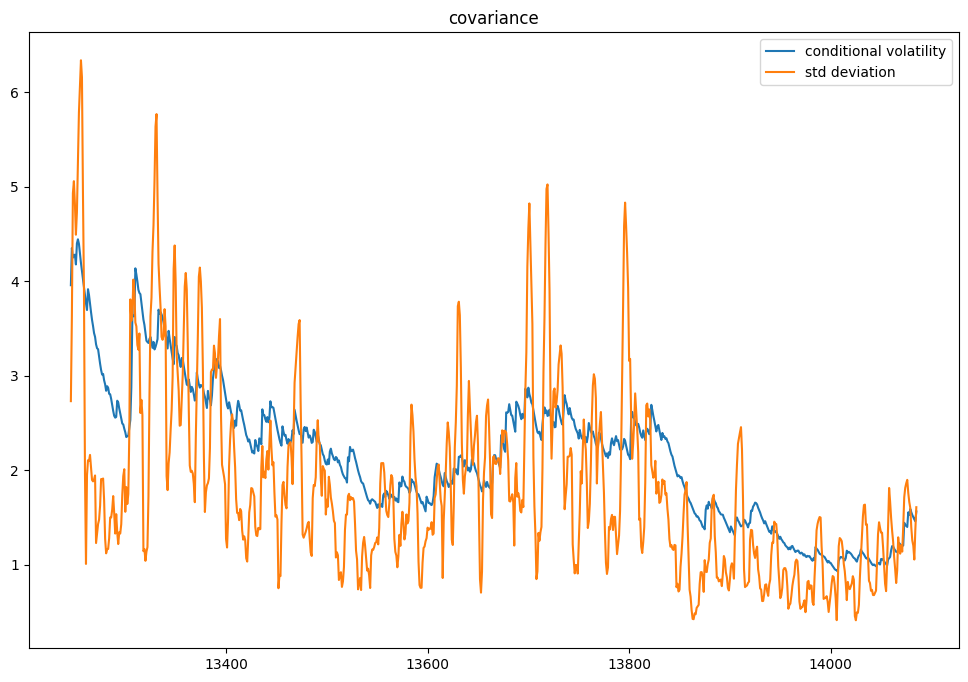

In [15]:
plt.figure(figsize=(12, 8))
plt.title(f'covariance')
plt.plot(conditional_volatility, label='conditional volatility')
plt.plot(df_day['rolling_std'], label='std deviation')

plt.legend()
#plt.savefig('backtest_vs_B&H.png', dpi=300)
plt.show()

In [16]:
#np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
#data = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", "olhc4", "momentum"]].dropna()

#features = ['log_returns',"kstlt", "kstmt"   ]  # '',  , 

#print(data.shape[0])
#hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
#hmm_model.fit(np.array(data[features]))
#print("Model Score: ", hmm_model.score(np.array(data[features])))

#data.head()


In [17]:

#data['state']=hmm_model.predict(np.array(data[features]))
#data.head()


analyse distribution des etats cahche

In [18]:
#MACD_FAST = 12
#MACD_SLOW = 26
#MACD_SIGNAL = 9

#macd,macdSignal, macdHist  = MACD(graph.olhc4, fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)

#graph.loc[:, 'macd'] = macd
#graph.loc[:, 'macdSignal'] = macdSignal
#graph.loc[:, 'macdHist'] = macdHist

#graph.head()

#fig = go.Figure(data=[go.Scatter(x=graph['SnapshotTime'], y=graph['macdHist'],  mode='lines+markers', marker = mark)])

#layout = go.Layout(template='plotly_dark',
#                   title ='macd' , height=500,
#                    xaxis_rangeslider_visible=True)
#fig.update_layout(layout)
#fig.show()

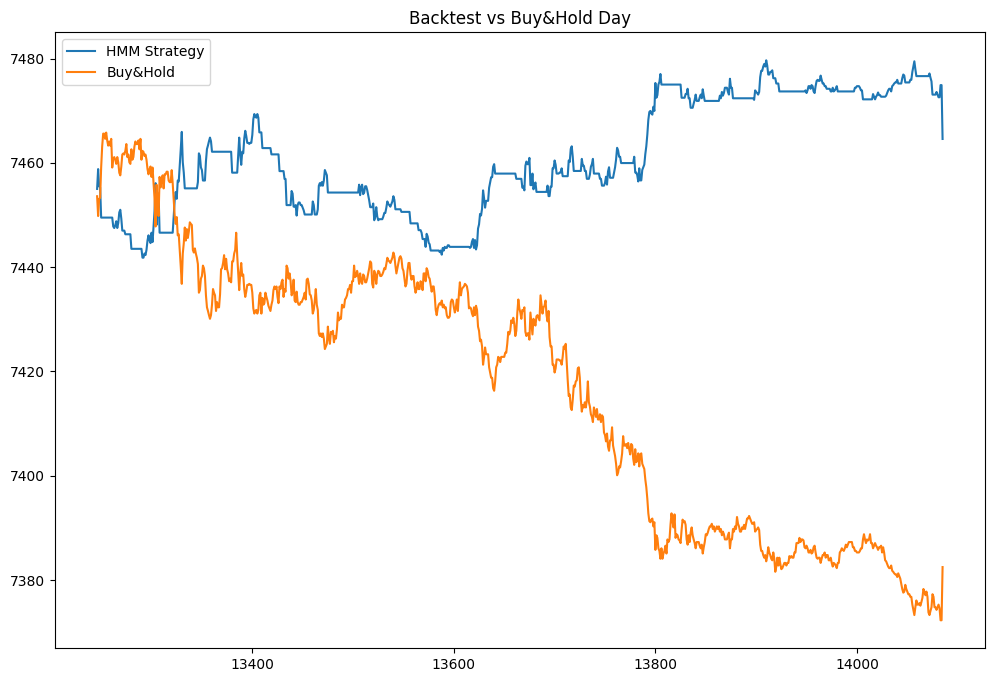

In [19]:
plt.figure(figsize=(12, 8))
plt.title(f'Backtest vs Buy&Hold Day')
plt.plot(np.exp(df_day['backtest'].mul(1)).cumprod().mul(df_day['closedprices'].iloc[0]), label='HMM Strategy')
plt.plot(np.exp(df_day['forward_returns'].mul(1)).cumprod().mul(df_day['closedprices'].iloc[0]), label='Buy&Hold')
plt.legend()
#plt.savefig('backtest_vs_B&H.png', dpi=300)
plt.show()

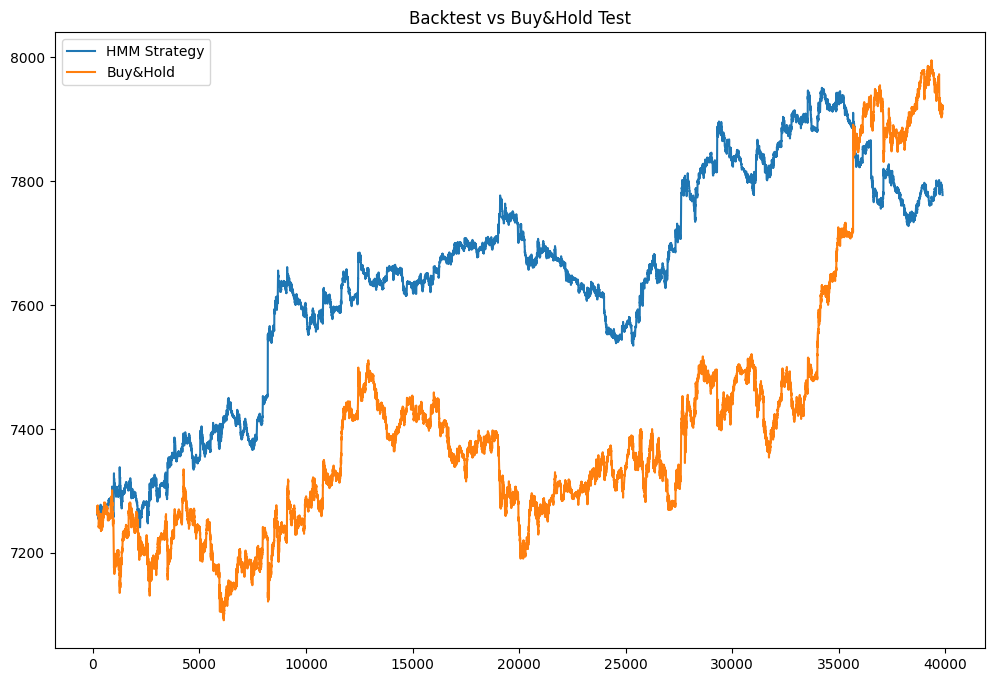

In [20]:
plt.figure(figsize=(12, 8))
plt.title('Backtest vs Buy&Hold Test')
plt.plot(np.exp(df_org['backtest'].mul(1)).cumprod().mul(df_org['closedprices'].iloc[0]), label='HMM Strategy')
plt.plot(np.exp(df_org['forward_returns'].mul(1)).cumprod().mul(df_org['closedprices'].iloc[0]), label='Buy&Hold')
plt.legend()
#plt.savefig('backtest_vs_B&H.png', dpi=300)
plt.show()

In [21]:
def calculer_metrics_portefeuille(resampled_returns, capital, operation, spread):
    # Calcul des paramètres annuels
    sigma = resampled_returns.std() * np.sqrt(356)
    mu = resampled_returns.mean() * 356

    # Ratio de Sharpe
    sharpe = mu / sigma

    # Evolution du portefeuille
    pf = capital * np.exp(resampled_returns).cumprod()

    # Drawdown maximal
    max_dd = -min(pf / pf.expanding(1).max() - 1)

    # Ratio de Calmar
    calmar = mu / max_dd

    # Volatilité des rendements négatifs
    sigma_neg = np.sqrt(np.mean(resampled_returns[resampled_returns < 0].pow(2))) * np.sqrt(356) #252 356

    # Ratio de Sortino
    sortino = mu / sigma_neg

    # Ajustement de la distribution des rendements avec Johnson SU
    a, b, loc, scale = johnsonsu.fit(resampled_returns)

    # Value at Risk au niveau de confiance de 99% pour 1 jour
    alpha_risk = 0.99
    VAR_99_1j = johnsonsu.ppf(1 - alpha_risk, a, b, loc, scale) * capital * -1

    # Approximation de la VaR pour 10 jours
    approx_VAR_99_10j = VAR_99_1j * np.sqrt(10)

    # Structurer les résultats dans un dictionnaire
    resultats = {
        'start' : capital,
        'gain point': pf.iloc[-1] - capital,
        'gain point net': pf.iloc[-1] - capital - (operation * spread),
        'operation' : operation,
        'Sharpe Ratio': sharpe,
        'Capital Final': pf.iloc[-1],
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Sortino Ratio': sortino,
        'VaR 99% 1 Jour': VAR_99_1j,
        'VaR 99% 10 Jours': approx_VAR_99_10j
    }

    # Formater et retourner les résultats
    return {k: f"{v:.5f}" for k, v in resultats.items()}

calculer_metrics_portefeuille(df_org['backtest'], df_org['closedprices'].iloc[0], df_org['operation'].sum(), 0.5)


#print( df_org['operation'].sum())

{'start': '7267.70000',
 'gain point': '510.01328',
 'gain point net': '-2812.98672',
 'operation': '6646.00000',
 'Sharpe Ratio': '0.15089',
 'Capital Final': '7777.71328',
 'Max Drawdown': '0.03118',
 'Calmar Ratio': '0.01955',
 'Sortino Ratio': '0.10145',
 'VaR 99% 1 Jour': '0.00000',
 'VaR 99% 10 Jours': '0.00000'}

In [22]:
calculer_metrics_portefeuille(df_day['backtest'], df_day['closedprices'].iloc[0],  df_day['operation'].sum(), 0.5)

{'start': '7454.30000',
 'gain point': '10.27821',
 'gain point net': '-64.22179',
 'operation': '149.00000',
 'Sharpe Ratio': '0.18364',
 'Capital Final': '7464.57821',
 'Max Drawdown': '0.00361',
 'Calmar Ratio': '0.16173',
 'Sortino Ratio': '0.11631',
 'VaR 99% 1 Jour': '0.00000',
 'VaR 99% 10 Jours': '0.00000'}

In [23]:
df_test.head()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,kstmt_filter_speed,state,position,signal,shifted_signal,fee,backtest,operation,kstlt_covariance,rolling_std
12406,"{'Ask': 7420.0, 'Bid': 7418.0, 'LastTraded': N...","{'Ask': 7420.2, 'Bid': 7418.2, 'LastTraded': N...",154,"{'Ask': 7414.4, 'Bid': 7410.4, 'LastTraded': N...","{'Ask': 7416.8, 'Bid': 7413.8, 'LastTraded': N...",2024-12-09 08:00:00,2024-12-09T07:00:00,7415.3,7419.2,7412.4,...,0.080979,1,0,0,1.0,0,0.000000,1,0.139046,2.664249
12407,"{'Ask': 7423.0, 'Bid': 7421.0, 'LastTraded': N...","{'Ask': 7425.0, 'Bid': 7423.0, 'LastTraded': N...",105,"{'Ask': 7419.7, 'Bid': 7417.7, 'LastTraded': N...","{'Ask': 7419.7, 'Bid': 7417.7, 'LastTraded': N...",2024-12-09 08:01:00,2024-12-09T07:01:00,7418.7,7424.0,7418.7,...,0.080738,1,0,0,0.0,0,0.000000,0,0.050197,2.927722
12408,"{'Ask': 7430.2, 'Bid': 7428.2, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",72,"{'Ask': 7423.5, 'Bid': 7421.5, 'LastTraded': N...","{'Ask': 7423.5, 'Bid': 7421.5, 'LastTraded': N...",2024-12-09 08:02:00,2024-12-09T07:02:00,7422.5,7430.0,7422.5,...,0.081285,1,0,1,0.0,0,-0.000229,1,0.018834,3.140789
12409,"{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",28,"{'Ask': 7428.2, 'Bid': 7426.2, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",2024-12-09 08:03:00,2024-12-09T07:03:00,7430.0,7430.0,7427.2,...,0.082137,1,0,1,1.0,0,-0.000040,0,0.019264,3.180164
12410,"{'Ask': 7428.2, 'Bid': 7426.2, 'LastTraded': N...","{'Ask': 7429.5, 'Bid': 7427.5, 'LastTraded': N...",35,"{'Ask': 7427.7, 'Bid': 7425.7, 'LastTraded': N...","{'Ask': 7428.7, 'Bid': 7426.7, 'LastTraded': N...",2024-12-09 08:04:00,2024-12-09T07:04:00,7427.7,7428.5,7426.7,...,0.083091,1,0,1,1.0,0,-0.000768,0,0.035930,3.204528


In [24]:
df_test.tail()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,kstmt_filter_speed,state,position,signal,shifted_signal,fee,backtest,operation,kstlt_covariance,rolling_std
39863,"{'Ask': 7916.5, 'Bid': 7914.5, 'LastTraded': N...","{'Ask': 7919.3, 'Bid': 7917.3, 'LastTraded': N...",31,"{'Ask': 7915.0, 'Bid': 7913.0, 'LastTraded': N...","{'Ask': 7918.3, 'Bid': 7916.3, 'LastTraded': N...",2025-01-31 21:54:00,2025-01-31T20:54:00,7917.3,7918.3,7914.0,...,-0.028939,1,0,-1,0.0,0,-0.000038,1,0.039993,2.682536
39864,"{'Ask': 7916.8, 'Bid': 7914.8, 'LastTraded': N...","{'Ask': 7917.5, 'Bid': 7915.5, 'LastTraded': N...",39,"{'Ask': 7915.3, 'Bid': 7913.3, 'LastTraded': N...","{'Ask': 7917.0, 'Bid': 7915.0, 'LastTraded': N...",2025-01-31 21:55:00,2025-01-31T20:55:00,7916.0,7916.5,7914.3,...,-0.017136,1,0,-1,-1.0,0,-0.000215,0,-0.020947,2.524194
39865,"{'Ask': 7918.5, 'Bid': 7916.5, 'LastTraded': N...","{'Ask': 7919.0, 'Bid': 7917.0, 'LastTraded': N...",32,"{'Ask': 7917.0, 'Bid': 7915.0, 'LastTraded': N...","{'Ask': 7917.0, 'Bid': 7915.0, 'LastTraded': N...",2025-01-31 21:56:00,2025-01-31T20:56:00,7916.0,7918.0,7916.0,...,-0.006156,1,0,-1,-1.0,0,0.000088,0,-0.025326,2.568268
39866,"{'Ask': 7917.8, 'Bid': 7915.8, 'LastTraded': N...","{'Ask': 7920.0, 'Bid': 7918.0, 'LastTraded': N...",29,"{'Ask': 7917.8, 'Bid': 7915.8, 'LastTraded': N...","{'Ask': 7918.8, 'Bid': 7916.8, 'LastTraded': N...",2025-01-31 21:57:00,2025-01-31T20:57:00,7917.8,7919.0,7916.8,...,0.003583,1,0,-1,-1.0,0,0.000126,0,-0.010950,2.588200
39867,"{'Ask': 7916.8, 'Bid': 7914.8, 'LastTraded': N...","{'Ask': 7918.3, 'Bid': 7916.3, 'LastTraded': N...",32,"{'Ask': 7915.0, 'Bid': 7913.0, 'LastTraded': N...","{'Ask': 7918.0, 'Bid': 7916.0, 'LastTraded': N...",2025-01-31 21:58:00,2025-01-31T20:58:00,7917.0,7917.3,7914.0,...,0.011929,1,0,-1,-1.0,0,-0.000505,0,-0.007555,2.359002


In [25]:


# Sample data
x = np.array([1, 2, 3, 4, 5])
y = np.array([-1, -2, 6, 8, -10])

# Calculate the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient
correlation_coefficient = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_matrix)

Correlation coefficient: [[ 1.        -0.1767767]
 [-0.1767767  1.       ]]


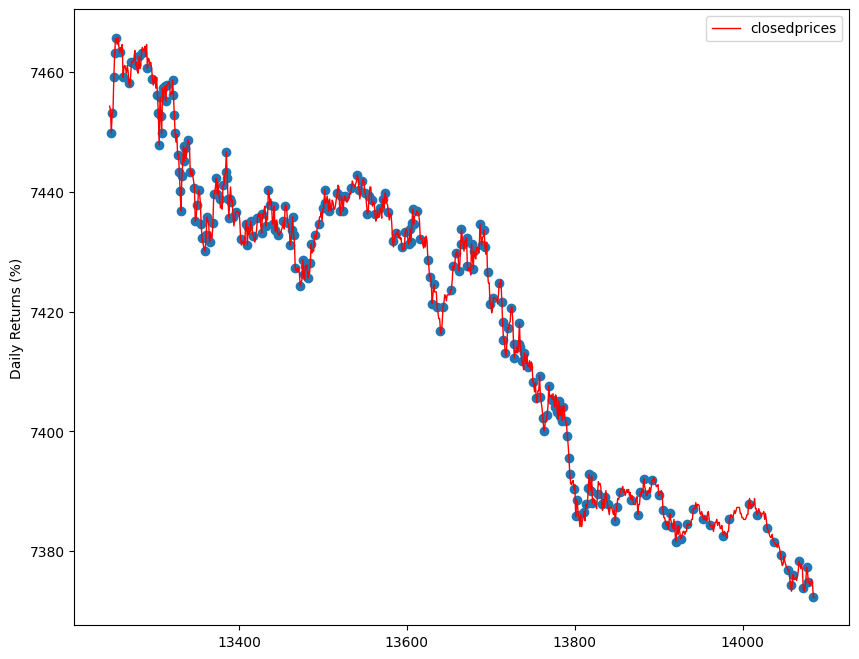

In [26]:

def getTEvents(gRaw,h):
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.Index(tEvents)

anomalies = getTEvents(df_day['closedprices'], h=2) # REQUIREMENT 3

fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(111,ylabel='Daily Returns (%)')
ax = df_day['closedprices'].plot(ax=ax1, color='r', lw=1, legend=True)
ax.scatter(anomalies, df_day['closedprices'].loc[anomalies])
plt.show()

In [27]:
# Sample data
series1 = np.array([1, 2, 3, 4, 5])
series2 = np.array([5, 4, 3, 2, 1])

# Compute covariance matrix
cov_matrix = np.cov(series1, series2)

# Extract the covariance value
covariance = cov_matrix[0, 1]
print("Covariance between series1 and series2:", covariance)

Covariance between series1 and series2: -2.5


In [28]:
import pandas as pd

# Sample data
series1 = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
series2 = pd.Series([5, 4, 3, 2, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

# Compute rolling covariance with a window of 20 points
rolling_covariance = series1.rolling(window=20).cov(series2)

print("Running covariance for 20 points:\n", rolling_covariance)

Running covariance for 20 points:
 0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19    33.947368
20    36.157895
21    37.473684
22    37.789474
23    37.000000
24    35.000000
dtype: float64


In [29]:
# Assuming df_day is your DataFrame
# Select the columns you want to save
#columns_to_save = df_day[['closedprices', 'olhc4_filter', 'olhc4_filter2']]

# Save the selected columns to a CSV file
#columns_to_save.to_csv('output.csv', index=False)